## Sparse convolution demo

In [1]:
import numpy as np
import sys
sys.path.append('/home/vlebedev/brain_damage/caffe/python')
import caffe
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!mkdir snapshots

In [2]:
#We start with training regular LeNet.
#You habe to copy mnist_test_lmdb and mnist_train_lmdb into this directory
#If this cell runs correctly, "net.caffemodel" file will appear
!sh train.sh 2> log
!ls *.caffemodel

net.caffemodel


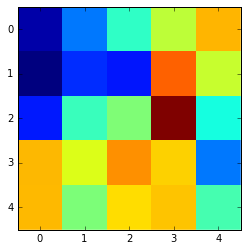

[[-0.38768244 -0.1925437  -0.03726823  0.12413661  0.25363147]
 [-0.42213988 -0.26055387 -0.28450063  0.33810511  0.13615094]
 [-0.27935869 -0.028331    0.05282414  0.51957804 -0.06722727]
 [ 0.24794148  0.16138721  0.29016444  0.22376081 -0.19043376]
 [ 0.24983175  0.05170694  0.21093683  0.23797756 -0.01192414]]


In [3]:
#visualize one of the filters of conv1 layer
net = caffe.Net('deploy.prototxt', 'net.caffemodel', caffe.TEST)
plt.imshow(net.layers[1].blobs[0].data[0,0,:,:], interpolation='None')
plt.show()

print net.layers[1].blobs[0].data[0,0,:,:]

sparsity = 0.360


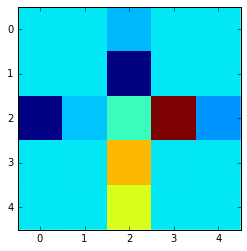

[[-0.         -0.         -0.03726823  0.          0.        ]
 [-0.         -0.         -0.28450063  0.          0.        ]
 [-0.27935869 -0.028331    0.05282414  0.51957804 -0.06722727]
 [ 0.          0.          0.29016444  0.         -0.        ]
 [ 0.          0.          0.21093683  0.         -0.        ]]


In [4]:
#convolutional weights sparsification
#all filters of both conv layers are sparsified according to the mask below

mask = np.array([
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

for l in [1, 3]:
    w = net.layers[l].blobs[0].data
    for x in range(5):
        for y in range(5):
            w[:,:,x,y] *= mask[x,y]

print("sparsity = %.3f" % np.mean(mask))
net.save('net%03d.caffemodel' % int(np.mean(mask) * 100))
            
plt.imshow(net.layers[1].blobs[0].data[0,0,:,:], interpolation='None')
plt.show()

print net.layers[1].blobs[0].data[0,0,:,:]

In [5]:
#test sparsified network
#accuracy drops
!sh test.sh net036.caffemodel 2> log
!tail -n 2 log

I0825 16:58:00.041175  1362 caffe.cpp:325] accuracy = 0.8468
I0825 16:58:00.041190  1362 caffe.cpp:325] loss = 1.16095 (* 1 = 1.16095 loss)


In [6]:
#finetune sparsified network
#currently backpropagation through sparse convolutional layers is not functional, 
#so in this example only fully connected layers are trained
!sh finetune1.sh net036.caffemodel 2> log
!tail -n 4 log

sparse layer: 9 of 25 elements are nonzero
sparse layer: 180 of 500 elements are nonzero
sparse layer: 9 of 25 elements are nonzero
sparse layer: 180 of 500 elements are nonzero
I0825 16:58:52.487483  1385 solver.cpp:404]     Test net output #0: accuracy = 0.9604
I0825 16:58:52.487563  1385 solver.cpp:404]     Test net output #1: loss = 0.184211 (* 1 = 0.184211 loss)
I0825 16:58:52.487576  1385 solver.cpp:322] Optimization Done.
I0825 16:58:52.487581  1385 caffe.cpp:254] Optimization Done.


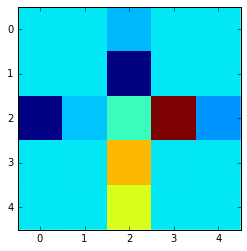

[[-0.         -0.         -0.03708363  0.          0.        ]
 [-0.         -0.         -0.28308386  0.          0.        ]
 [-0.27797064 -0.0281907   0.05256205  0.51701593 -0.06689493]
 [ 0.          0.          0.28872487  0.         -0.        ]
 [ 0.          0.          0.20989144  0.         -0.        ]]


In [7]:
#check if sparsity structure is preserved
net = caffe.Net('deploy.prototxt', 'snapshots/net_tuned1_iter_1000.caffemodel', caffe.TEST)
w = net.layers[1].blobs[0].data[0,0,:,:]
plt.imshow(w, interpolation='None')
plt.show()
print w

In [10]:
#alternative way to tune network is to use regular convolutions,
#but fix zero weights with special regularizer
#now, all layers are tuned and final result is better
!sh finetune2.sh net036.caffemodel 2> log
!tail -n 4 log

I0825 17:00:30.651470  2220 solver.cpp:404]     Test net output #0: accuracy = 0.9789
I0825 17:00:30.651525  2220 solver.cpp:404]     Test net output #1: loss = 0.0754681 (* 1 = 0.0754681 loss)
I0825 17:00:30.651538  2220 solver.cpp:322] Optimization Done.
I0825 17:00:30.651546  2220 caffe.cpp:254] Optimization Done.


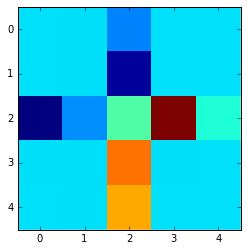

[[-0.         -0.         -0.08586697  0.          0.        ]
 [-0.         -0.         -0.30886415  0.          0.        ]
 [-0.33464116 -0.07558403  0.10055682  0.63681138  0.04160528]
 [ 0.          0.          0.42946491  0.         -0.        ]
 [ 0.          0.          0.37419415  0.         -0.        ]]


In [11]:
#check if sparsity structure is preserved
net = caffe.Net('deploy.prototxt', 'snapshots/net_tuned2_iter_1000.caffemodel', caffe.TEST)
w = net.layers[1].blobs[0].data[0,0,:,:]
plt.imshow(w, interpolation='None')
plt.show()
print w